In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn import preprocessing

In [2]:
EXTRACTED_FEATURES_DB_NAME = '/data/experiments/YHE-R/extracted-features/extracted-features.sqlite'

In [3]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query("select * from features", db_conn)
db_conn.close()

In [4]:
sequences_df.classed_as.unique()

array(['decoy', 'target'], dtype=object)

In [5]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_isotope_cv', 'rt_peak_symmetry_0',
       'rt_peak_symmetry_1', 'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_isotope_cv', 'scan_peak

In [7]:
sequences_df[['sequence','charge','run_name','human','group','classed_as']].sample(n=5)

,sequence,charge,run_name,human,group,classed_as
170094,TAIEAMAAVFGGTQSLHTNSFDEALGLPTVK,3,YHE211_10_Slot1-1_1_3006,1,YHE211,target
368236,M[15.9949]EAWGGPEELGLAPAPNPR,2,YHE211_08_Slot1-1_1_3004,1,YHE211,target
108171,Q[-17.0265]DLM[15.9949]NIAGTTLSSK,2,YHE114_10_Slot1-1_1_3017,1,YHE114,target
44428,LLGGVTIAQGGVLPNIQAVLLPK,2,YHE114_06_Slot1-1_1_3013,1,YHE114,target
645403,AVAFQNPQTHVIENLHAAAYR,3,YHE010_02_Slot1-1_1_2987,1,YHE010,target


In [8]:
sequences_df['group'] = sequences_df.run_name.apply(lambda x: x.split('_')[0])

In [10]:
sequences_df[['sequence','charge','run_name','human','group']].sample(n=5)

,sequence,charge,run_name,human,group
120724,DIELHLESSSHQETLDHIQK,4,YHE114_07_Slot1-1_1_3014,1,YHE114
4927,DYIAYAHSTIMPR,2,YHE114_11_Slot1-1_1_3043,1,YHE114
155271,GDLENAFLNLVQCIQNKPLYFADR,3,YHE211_10_Slot1-1_1_3006,1,YHE211
654868,IAQDLEMYGVNYFSIK,2,YHE010_02_Slot1-1_1_2987,1,YHE010
809895,QTRPVQSWLCDPDAMEQGETPLTMLQSQVPNIVK,3,YHE114_05_Slot1-1_1_3012,1,YHE114


In [11]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE211') | (sequences_df.group == 'YHE114')]
yhe_only_targets_df = yhe_only_df[(yhe_only_df.classed_as == 'target')]

In [12]:
number_of_yhe_runs_in_experiment = len(yhe_only_df.file_idx.unique())
print('there are {} runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 21 runs in the experiment


#### analyse the rate of successful extractions of peptides in the library

In [13]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.file_idx.unique())))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [14]:
# display the number of missing extractions across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of extractions missing across the experiment.".format(round(proportion_of_missing_extractions*100)))

1.0% of extractions missing across the experiment.


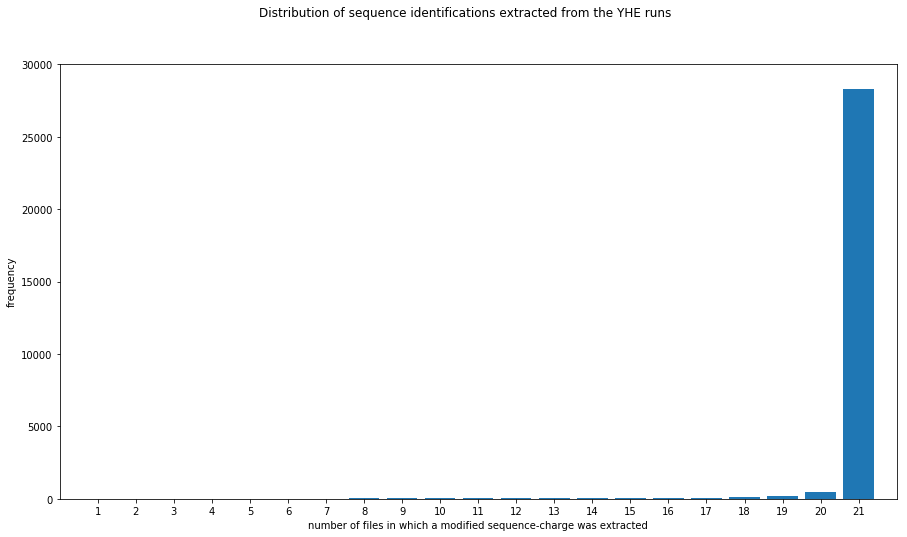

In [15]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications extracted from the YHE runs')
# plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

In [16]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in yhe_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1]))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge'])

In [17]:
# display the number of missing values across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values are missing across the YHE-only runs.".format(round(proportion_of_missing_values*100)))

11.0% of values are missing across the YHE-only runs.


In [18]:
yhe_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
12555,IPEGTILTMDMLTVK,2,21,0
12364,ILSNLPESSLTDLPAVTK,2,20,1
24054,TGLSSEQTVNVLAQILK,2,21,0
28087,YESATASALVN,1,20,1
25662,VDEFPLCGHMVSDEYEQLSSEALEAAR,3,21,0
5854,EHEWLR,2,21,0
15400,LNGGNCLVHCFAGISR,2,21,0
17745,NECDPALALLSDYVLHNSNTMR,2,21,0
3066,DDGISFSNQTGPAWAGSER,2,14,7
23109,STHNEDQASCEVLTVK,2,12,9


In [20]:
df = yhe_only_df[(yhe_only_df.sequence == 'TGLSSEQTVNVLAQILK') & (yhe_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
24301,TGLSSEQTVNVLAQILK,2,15,target,0.999820
53571,TGLSSEQTVNVLAQILK,2,30,target,0.999848
82787,TGLSSEQTVNVLAQILK,2,8,target,0.999836
112080,TGLSSEQTVNVLAQILK,2,17,target,0.999859
141334,TGLSSEQTVNVLAQILK,2,18,target,0.999908
170638,TGLSSEQTVNVLAQILK,2,7,target,0.999785
229076,TGLSSEQTVNVLAQILK,2,25,target,0.999826
345660,TGLSSEQTVNVLAQILK,2,14,target,0.999849
374907,TGLSSEQTVNVLAQILK,2,28,target,0.999734
404189,TGLSSEQTVNVLAQILK,2,26,target,0.999365


In [21]:
len(yhe_only_df[yhe_only_df.classed_as == 'decoy']) / len(yhe_only_df[yhe_only_df.classed_as == 'target'])

0.1326503358807591

In [22]:
unique_sequences_yhe_df = yhe_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_yhe_df)

29551

In [23]:
unique_sequences_all_runs_df = sequences_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_all_runs_df)

29552

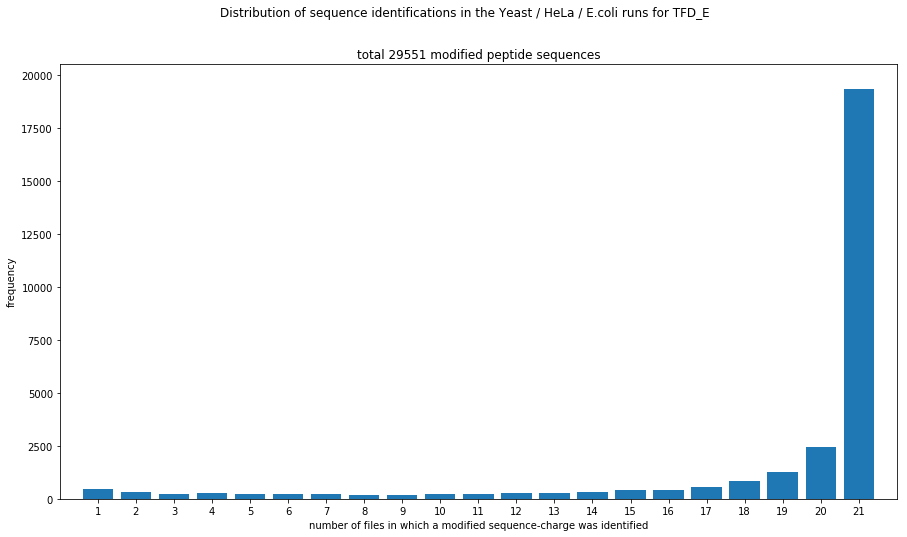

In [24]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the Yeast / HeLa / E.coli runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_yhe_df)))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

#### now analyse the human-only runs

In [25]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')].copy()
human_only_targets_df = human_only_df[(human_only_df.classed_as == 'target')]

In [26]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1], group_df.iloc[0].human))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge','human'])


In [27]:
# proportion of false positives i.e. non-human peptides found in the human-only runs
print('false positives: {}%'.format(round(len(human_sequence_occurences_df[(human_sequence_occurences_df.human == 0)]) / len(human_sequence_occurences_df) * 100.0, 1)))

false positives: 16.5%


In [28]:
number_of_human_runs_in_experiment = len(human_only_df.file_idx.unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 human-only runs in the experiment


In [29]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values are missing in the human-only runs.".format(round(proportion_of_missing_values*100)))

14.0% of values are missing in the human-only runs.


In [30]:
human_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
14823,LNSKPQDLTDAYGPPSNFLEIDIFNPQTVGVGR,3,7,3
12128,IPVGPETLGR,2,10,0
23672,TPETVVPTALELQPSTSTDRPVTSEPTSQATR,3,2,8
21632,SNLAYDIVQLPTGLTGIK,3,7,3
21106,SGSHTVAVMNVGAPAAGMNAAVR,2,10,0
7145,FDLLASNFPPLPGSSSR,2,10,0
8183,FVPFAAVAAANCINIPLMR,2,10,0
156,AAQYVASHPGEVCPAK,2,2,8
12653,KAPDFVFYAPR,2,10,0
12367,ITEDYYVHLIADNLPVATR,3,4,6


In [31]:
df = human_only_df[(human_only_df.sequence == 'APVAIGVAAMSTAEMLTSGLK') & (human_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
177265,APVAIGVAAMSTAEMLTSGLK,2,9,target,0.990709
235669,APVAIGVAAMSTAEMLTSGLK,2,5,target,0.998446
264576,APVAIGVAAMSTAEMLTSGLK,2,22,target,0.998934
293853,APVAIGVAAMSTAEMLTSGLK,2,16,target,0.998695
440125,APVAIGVAAMSTAEMLTSGLK,2,2,target,0.997307
586424,APVAIGVAAMSTAEMLTSGLK,2,1,target,0.996677
615684,APVAIGVAAMSTAEMLTSGLK,2,12,target,0.934483
644941,APVAIGVAAMSTAEMLTSGLK,2,6,target,0.987191
849976,APVAIGVAAMSTAEMLTSGLK,2,4,target,0.999677
879162,APVAIGVAAMSTAEMLTSGLK,2,3,target,0.999553


In [32]:
len(df)

10

In [33]:
unique_sequences_human_only_df = human_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_human_only_df)

29524

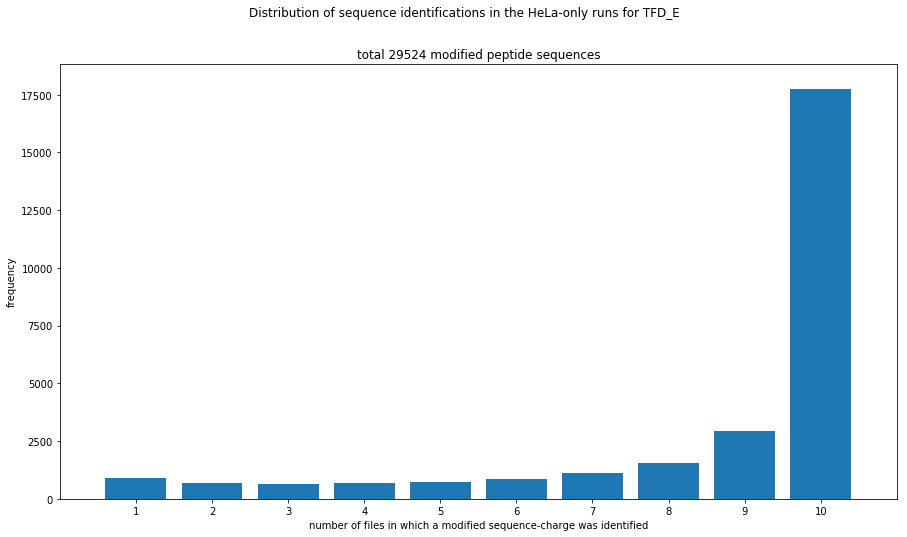

In [34]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
# plt.ylim((0,20000))

plt.show()

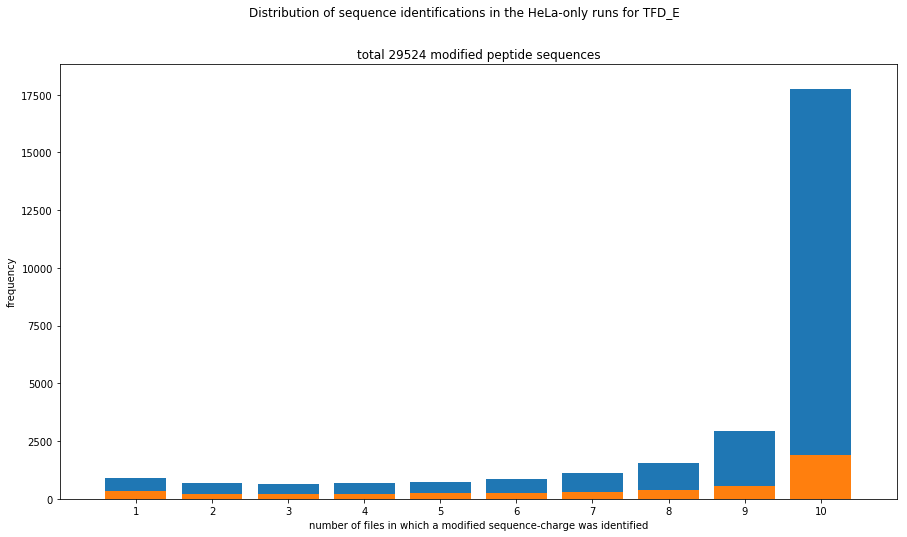

In [35]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts_human = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == True].number_of_runs_targets_extracted)
counts_other = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == False].number_of_runs_targets_extracted)

ax1.bar(range(11), counts_human, bottom=counts_other, width=0.8, align='center')
ax1.bar(range(11), counts_other, width=0.8, align='center')

plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
# plt.ylim((0,20000))

plt.show()

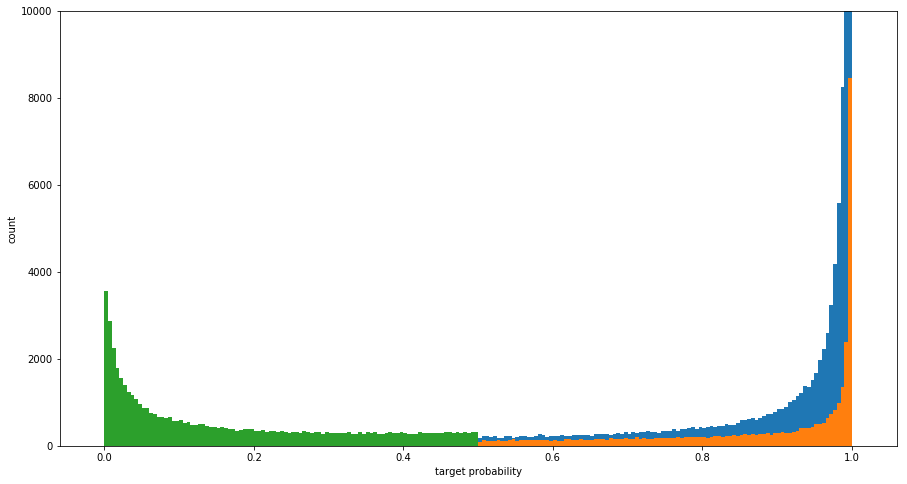

In [36]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values_targets_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].prob_target
values_targets_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].prob_target
values_decoys = human_only_df[human_only_df.classed_as == 'decoy'].prob_target

y, x, _ = ax1.hist(values_targets_human, bins=bins)
y, x, _ = ax1.hist(values_targets_other, bins=bins)
y, x, _ = ax1.hist(values_decoys, bins=bins)
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('target probability')
plt.ylabel('count')
# plt.title('pre-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
# plt.xlim((0,120))
plt.ylim((0,10000))

plt.show()

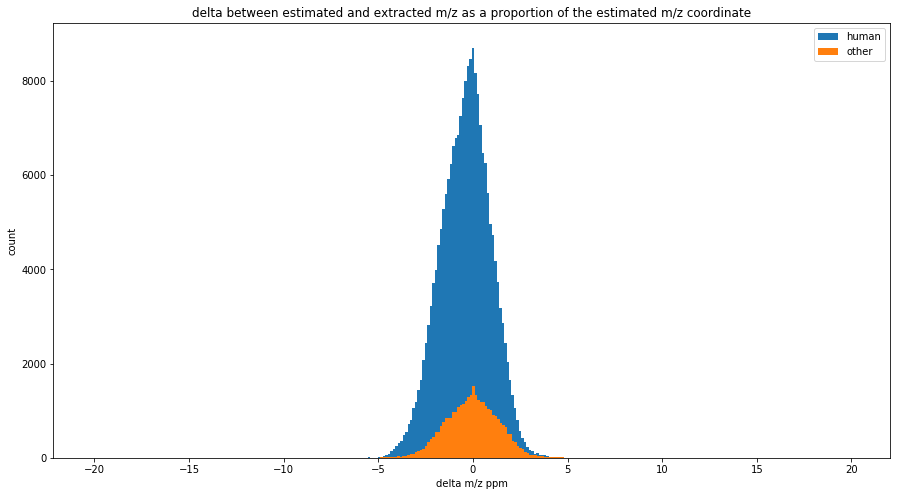

In [37]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
mz_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_mz_ppm
mz_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_mz_ppm

y, x, _ = ax1.hist(mz_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(mz_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta m/z ppm')
plt.ylabel('count')
plt.title('delta between estimated and extracted m/z as a proportion of the estimated m/z coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
# plt.ylim((0,10000))

plt.show()

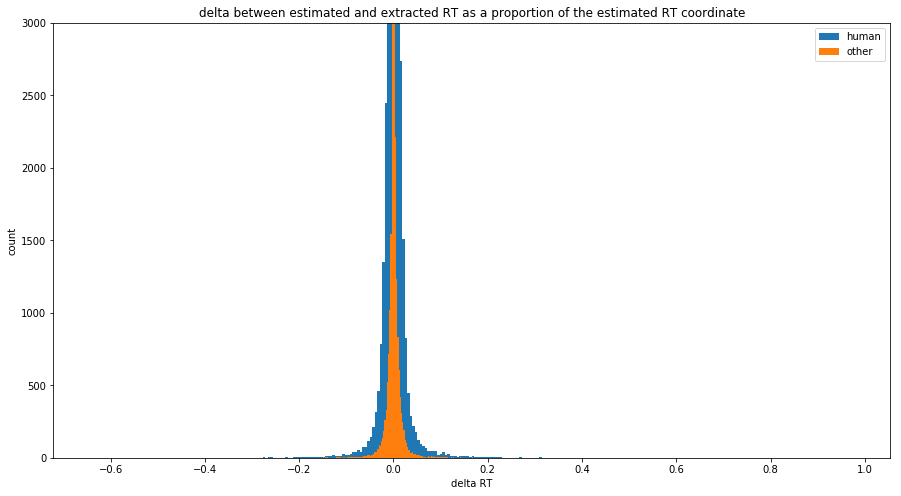

In [38]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
rt_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_rt
rt_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_rt

y, x, _ = ax1.hist(rt_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(rt_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta RT')
plt.ylabel('count')
plt.title('delta between estimated and extracted RT as a proportion of the estimated RT coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,3000))

plt.show()

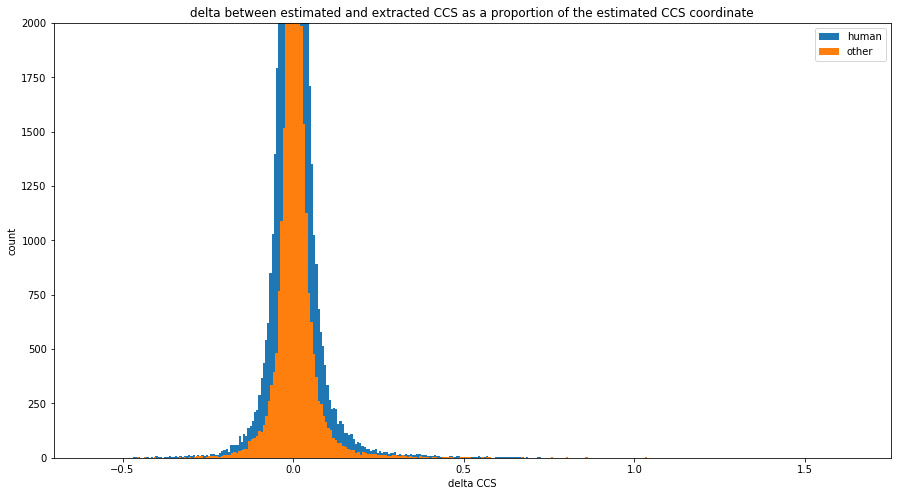

In [39]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
scan_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_scan
scan_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_scan

y, x, _ = ax1.hist(scan_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(scan_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta CCS')
plt.ylabel('count')
plt.title('delta between estimated and extracted CCS as a proportion of the estimated CCS coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,2000))

plt.show()

In [40]:
df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False) & (abs(human_only_df.delta_scan <= 0.1)) & (abs(human_only_df.delta_rt <= 0.05)) & (abs(human_only_df.delta_mz_ppm <= 1))]

len(df)

25234

In [41]:
len(df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))

4426

In [42]:
human_only_df['sequence_charge'] = human_only_df.apply(lambda row: '{}-{}'.format(row.sequence, row.charge), axis=1)

In [43]:
human_only_df.target_coords = human_only_df.apply(lambda row: json.loads(row.target_coords), axis=1)

In [44]:
human_only_df['estimated_rt_apex'] = human_only_df.apply(lambda row: row.target_coords['rt_apex'], axis=1)
human_only_df['estimated_scan_apex'] = human_only_df.apply(lambda row: row.target_coords['scan_apex'], axis=1)
human_only_df['estimated_monoisotopic_mz'] = human_only_df.apply(lambda row: row.target_coords['mono_mz'], axis=1)

In [45]:
human_only_df['absolute_delta_rt'] = human_only_df.delta_rt * human_only_df.estimated_rt_apex
human_only_df['absolute_delta_scan'] = human_only_df.delta_scan * human_only_df.estimated_scan_apex

In [46]:
non_human_df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)]
human_df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)]

In [47]:
len(non_human_df)

34211

In [48]:
len(human_df)

205505

In [49]:
non_human_df.sample(n=5)

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,scan_apex,run_name,group,human,sequence_charge,estimated_rt_apex,estimated_scan_apex,estimated_monoisotopic_mz,absolute_delta_rt,absolute_delta_scan
849809,ANITDVCIAVPPWYTEEQR,2,4,0,"{'mono_mz': 1131.5447926533964, 'scan_apex': 3...",1131.546608,0.000003,-0.422554,0.001128,0.063959,...,397,YHE010_10_Slot1-1_1_2995,YHE010,0,ANITDVCIAVPPWYTEEQR-2,2012.379177,373.134805,1131.544793,2.269613,23.865195
666904,SYYMLQEILETIK,2,6,0,"{'mono_mz': 815.9244854200874, 'scan_apex': 53...",815.923476,0.000446,0.534381,-0.003984,-0.044322,...,511,YHE010_02_Slot1-1_1_2987,YHE010,0,SYYMLQEILETIK-2,2222.583726,534.699193,815.924485,-8.854790,-23.699193
591432,EPQHQAAVPVSQEENER,2,1,0,"{'mono_mz': 974.4626292985434, 'scan_apex': 51...",974.461376,0.005202,1.939198,0.006184,0.013291,...,518,YHE010_05_Slot1-1_1_2990,YHE010,0,EPQHQAAVPVSQEENER-2,1537.932695,511.205616,974.462629,9.509837,6.794384
858591,GTITWIAPAGEYTLDEK,2,4,1,"{'mono_mz': 932.9702608227395, 'scan_apex': 46...",932.969976,0.001871,1.945180,-0.007326,0.057279,...,487,YHE010_10_Slot1-1_1_2995,YHE010,0,GTITWIAPAGEYTLDEK-2,1928.410925,460.616304,932.970261,-14.127178,26.383696
442463,DLPENIILTSLMR,2,2,0,"{'mono_mz': 757.9169292645789, 'scan_apex': 57...",757.915976,0.000846,-2.040079,0.000425,0.007783,...,580,YHE010_03_Slot1-1_1_2988,YHE010,0,DLPENIILTSLMR-2,2193.550697,575.520757,757.916929,0.932354,4.479243


In [50]:
human_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_isotope_cv', 'rt_peak_symmetry_0',
       'rt_peak_symmetry_1', 'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_isotope_cv', 'scan_peak

In [51]:
MZ_TOLERANCE_PPM = 5  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

RT_DELTA = 1.0    # tolerance for the RT apex to be a neighbour
CCS_DELTA = 1.0   # tolerance for the CCS apex to be a neighbour

In [52]:
1029.99 * MZ_TOLERANCE_PERCENT / 100

0.0051499499999999995

In [53]:
# count how many human sequences are in the same place in the same file as each non-human sequence
number_of_human_neighbours_l = []
for row in non_human_df.itertuples():
    MZ_DELTA = row.monoisotopic_mz_centroid * MZ_TOLERANCE_PERCENT / 100

    human_neighbours_df = human_df[(human_df.file_idx == row.file_idx) &
                                   (abs(human_df.monoisotopic_mz_centroid - row.monoisotopic_mz_centroid) <= MZ_DELTA) &
                                   (abs(human_df.rt_apex - row.rt_apex) <= RT_DELTA) &
                                   (abs(human_df.scan_apex - row.scan_apex) <= CCS_DELTA)
                                  ]
    neighbours_l = human_neighbours_df.sequence_charge.to_list()
    number_of_human_neighbours_l.append((row.sequence, row.charge, row.file_idx, len(human_neighbours_df), neighbours_l))


In [54]:
number_of_human_neighbours_df = pd.DataFrame(number_of_human_neighbours_l, columns=['sequence','charge','file_idx','number_of_human_neighbours','human_neighbours'])

In [55]:
number_of_human_neighbours_df[number_of_human_neighbours_df.number_of_human_neighbours >= 1]

,sequence,charge,file_idx,number_of_human_neighbours,human_neighbours
5,AADETAAAFYPSK,2,9,1,[ILYSQCGDVMR-2]
6,AADGQM[15.9949]VPFSAFSSSR,2,9,1,[AALTHNDNHFNYEK-2]
116,AIMGLPLTPYPVEK,2,9,1,[DPVQLNLLYVQAR-2]
129,ALELWGIPKTIGDLKDIFIK,3,9,1,[IAELLENVTLIHKPVSLQPR-3]
158,ANGNSFEFGPWEDIPR,2,9,1,[M[15.9949]TDQEAIQDLWQWR-2]
...,...,...,...,...,...
33923,VQAPTAYKPSYAHR,2,3,1,[LDYNNIPTVVFSHPPIGTVGLTEDEAIHK-4]
34175,YSLENTGSVEETVER,2,3,1,[GYAFVHFETQEAADK-2]
34180,YSTFAQTTSSEQTGQEK,2,3,1,[AQENYEGSEEVSPPQTK-2]
34207,YYSEEYPLDFAAVECEDSVNDK,2,3,1,[HCQLEPDHEGVPEETDDFGEFR-2]


In [56]:
number_of_human_neighbours_df.number_of_human_neighbours.unique()

array([0, 1, 2])

In [57]:
unique_values = len(number_of_human_neighbours_df.number_of_human_neighbours.unique())
unique_values

3

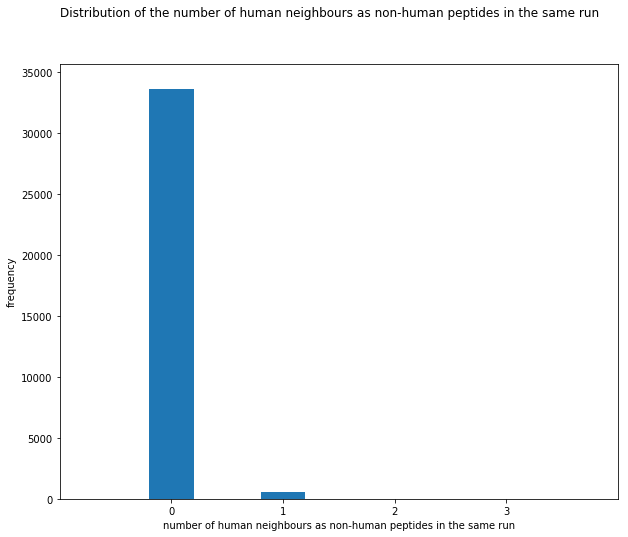

In [58]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)

plt.margins(0.06)
plt.suptitle('Distribution of the number of human neighbours as non-human peptides in the same run')
# plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts_neighbours = np.bincount(number_of_human_neighbours_df.number_of_human_neighbours)

ax1.bar(range(unique_values), counts_neighbours, width=0.4, align='center')

plt.xlabel('number of human neighbours as non-human peptides in the same run')
plt.ylabel('frequency')
ax1.set(xticks=range(0,unique_values+1), xlim=[-1, unique_values+1])
# plt.ylim((0,2000))

plt.show()

In [59]:
non_human_peptide = non_human_df[(non_human_df.sequence == 'VEVETPEENTGDVIGDLSR') & (non_human_df.charge == 2) & (non_human_df.file_idx == 7)].iloc[0]
non_human_peptide[['sequence','charge','human','monoisotopic_mz_centroid','scan_apex','rt_apex','estimated_monoisotopic_mz','estimated_scan_apex','estimated_rt_apex']]


IndexError: single positional indexer is out-of-bounds

In [ ]:
human_peptide = human_df[(human_df.sequence == 'LDEMEFNPVQQPQLNEK') & (human_df.charge == 2) & (human_df.file_idx == 7)].iloc[0]
human_peptide[['sequence','charge','human','monoisotopic_mz_centroid','scan_apex','rt_apex','estimated_monoisotopic_mz','estimated_scan_apex','estimated_rt_apex']]


In [ ]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
rt_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].absolute_delta_rt
rt_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].absolute_delta_rt

y, x, _ = ax1.hist(rt_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(rt_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta RT')
plt.ylabel('count')
plt.title('absolute delta between estimated and extracted RT')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,3000))

plt.show()

In [ ]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
scan_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].absolute_delta_scan
scan_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].absolute_delta_scan

y, x, _ = ax1.hist(scan_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(scan_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta CCS')
plt.ylabel('count')
plt.title('absolute delta between estimated and extracted CCS')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,2000))

plt.show()

In [ ]:
human_only_targets_df.columns

#### during feature extraction for each peptide in the library, for each run we have extracted one feature for each sequence. Now we need to make sure each feature has only been assigned to one sequence.

In [ ]:
sequence_targets_df = sequences_df[(sequences_df.classed_as == 'target')].copy()

In [ ]:
def myround(x, base=5):
    return base * round(x/base)

In [ ]:
# normalise the deltas so we can compute the Euclidean distance
sequence_targets_df['delta_mz_ppm_normed'] = (sequence_targets_df.delta_mz_ppm - sequence_targets_df.delta_mz_ppm.min())/(sequence_targets_df.delta_mz_ppm.max() - sequence_targets_df.delta_mz_ppm.min())
sequence_targets_df['delta_rt_normed'] = (sequence_targets_df.delta_rt - sequence_targets_df.delta_rt.min())/(sequence_targets_df.delta_rt.max() - sequence_targets_df.delta_rt.min())
sequence_targets_df['delta_scan_normed'] = (sequence_targets_df.delta_scan - sequence_targets_df.delta_scan.min())/(sequence_targets_df.delta_scan.max() - sequence_targets_df.delta_scan.min())


In [ ]:
sequence_targets_df.sample(n=5)

In [ ]:
# for each run, find any duplicate extractions
features_l = []
for group_name,group_df in sequence_targets_df.groupby(['file_idx'], as_index=False):
    df = group_df.copy()
    df['rounded_monoisotopic_mz_centroid'] = round(df.monoisotopic_mz_centroid,2)
    df['rounded_rt_apex'] = myround(df.rt_apex, base=10)
    df['rounded_scan_apex'] = myround(df.scan_apex, base=10)
    feature_id = 1
    for feature_group_name,feature_group_df in df.groupby(['charge','rounded_monoisotopic_mz_centroid','rounded_rt_apex','rounded_scan_apex'], as_index=False):
        df2 = feature_group_df.copy()
        df2['distance'] = df2.apply(lambda row: ((row.delta_mz_ppm_normed ** 2) + (row.delta_scan_normed ** 2) + (row.delta_rt_normed ** 2)) ** 0.5, axis=1)
        df2.sort_values(by=['distance'], ascending=True, inplace=True)
        sequences_l = df2[['sequence','human','group','monoisotopic_mz_centroid','rt_apex','scan_apex','distance']].to_dict('records')
        selected_sequence = sequences_l[0]['sequence']
        selected_sequence_human = sequences_l[0]['human']
        selected_sequence_group = sequences_l[0]['group']
        features_l.append((group_name,feature_id,feature_group_name[0],feature_group_name[1],feature_group_name[2],feature_group_name[3],len(feature_group_df),sequences_l,selected_sequence,selected_sequence_human,selected_sequence_group))
        feature_id += 1
        

In [ ]:
features_df = pd.DataFrame(features_l, columns=['file_idx','feature_id','charge','rounded_monoisotopic_mz_centroid','rounded_rt_apex','rounded_scan_apex','number_of_sequences','sequences','selected_sequence','selected_sequence_human','selected_sequence_group'])


#### analysing the human-only runs

In [ ]:
human_only_runs_df = features_df[(features_df.selected_sequence_group == 'YHE010')].copy()

In [ ]:
human_only_runs_df.sample(n=10)

In [ ]:
human_only_runs_df.number_of_sequences.value_counts()

In [ ]:
len(human_only_runs_df[(human_only_runs_df.number_of_sequences == 1) & (human_only_runs_df.selected_sequence_human == 0)])

In [ ]:
len(human_only_runs_df[(human_only_runs_df.number_of_sequences > 1) & (human_only_runs_df.selected_sequence_human == 0)])

In [ ]:
# proportion of non-human peptides found that have a feature assigned to more than one sequence
len(human_only_runs_df[(human_only_runs_df.number_of_sequences > 1) & (human_only_runs_df.selected_sequence_human == 0)]) / len(human_only_runs_df[(human_only_runs_df.number_of_sequences == 1) & (human_only_runs_df.selected_sequence_human == 0)])

In [ ]:
len(human_only_runs_df[(human_only_runs_df.number_of_sequences > 1)])


In [ ]:
human_only_runs_df[(human_only_runs_df.number_of_sequences == 2) & (human_only_runs_df.selected_sequence_human == 0)].sample(n=5)

In [ ]:
human_only_runs_df[(human_only_runs_df.number_of_sequences == 2) & (human_only_runs_df.selected_sequence_human == 1)].sample(n=5)

In [ ]:
human_only_runs_df.loc[384137].sequences

In [ ]:
print('FDR (number of non-human sequences out of total number): {}%'.format(round(len(human_only_runs_df[human_only_runs_df.selected_sequence_human == 0]) / len(human_only_runs_df) * 100,1)))

In [ ]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_runs_df.groupby(['selected_sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1], group_df.iloc[0].selected_sequence_human))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge','human'])


In [ ]:
number_of_human_runs_in_experiment = len(human_only_runs_df.file_idx.unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

In [ ]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values are missing in the human-only runs.".format(round(proportion_of_missing_values*100)))